In [1]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import xarray as xr
import string

import arke
from arke.cart import lcc_map, lcc_map_grid

from common_defs import winters, nyr, winter_dates, aliases, datasets, period, bbox
from plot_utils import LCC_KW, trans, use_style
import mypaths

from octant.core import TrackRun
from octant.decor import get_pbar
from octant.misc import calc_all_dens, DENSITY_TYPES
import octant

octant.__version__

'v0.0.21+0.g96be4b6.dirty'

In [2]:
from scipy.ndimage.filters import gaussian_filter

In [3]:
octant.RUNTIME.enable_progress_bar = True

pbar = get_pbar()

In [4]:
from categorise_and_save import get_lsm

In [5]:
import warnings

# warnings.filterwarnings("ignore", category=RuntimeWarning, module="dask")
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

## Calculate density

#### Runs and subsets to process and method of density calculation

In [6]:
runs2process = dict(era5=[0], interim=[0])
subsets = ["pmc"]
method = "cell"

#### Grids and arrays for density calculation

In [7]:
# extent = [-20, 50, 65, 85]

lon_dens1d = np.arange(-20.0, 50.1, 0.5)  # 0.3)
lat_dens1d = np.arange(65.0, 85.1, 0.5)  # 0.3)
grid_str = "0p5deg"

#### Load TrackRuns and calculate density if a file with result does not exist

In [8]:
for dset in pbar(datasets):
    for run_num in pbar(runs2process[dset]):
        fname = (
            mypaths.procdir / f"all_dens_{dset}_run{run_num:03d}_{period}_{method}_{grid_str}_addcat.nc"
        )

        if not fname.exists():
            tr = TrackRun.from_archive(mypaths.procdir / f"{dset}_run{run_num:03d}_{period}.h5")
            
            tr.categorise_by_percentile('max_vort', subset='pmc', perc=90)
            tr.categorise_by_percentile(('min_slp', lambda x: np.nanmin(x.slp.values)), subset='pmc', perc=10, oper='le')

            all_dens = calc_all_dens(tr, lon_dens1d, lat_dens1d, method=method)
            attrs = all_dens.attrs.copy()
            all_dens /= nyr
            # all_dens = xr.apply_ufunc(smooth_func, all_dens, kwargs=kwargs)
            # attrs["smooth"] = f"{smooth_func.__module__}.{smooth_func.__name__} with {kwargs}"
            # all_dens.attrs.update(attrs)
            all_dens.to_netcdf(fname)

In [9]:
# from ipywidgets import interact


# @interact(
#     dens_type=DENSITY_TYPES,
#     subset=["pmc"],
#     sigma_y=(0, 5, 0.1),
#     sigma_x=(0, 5, 0.1),
#     _grid_str=["0p5deg", "1deg", "2deg"],
# )
# def fun(dens_type="track", subset="pmc", sigma_y=1, sigma_x=2.5, _grid_str="1deg"):

#     fig = plt.figure(figsize=(20, 10))

#     for i, dset in enumerate(datasets):
#         ax = lcc_map(fig, 121 + i, **LCC_KW)

#         dens_ds = xr.open_dataarray(
#             mypaths.procdir / f"all_dens_{dset}_run{run_num:03d}_{period}_{method}_{_grid_str}.nc"
#         )

#         data = xr.apply_ufunc(
#             smooth_func,
#             dens_ds.sel(subset=subset, dens_type=dens_type),
#             kwargs={"sigma": (sigma_y, sigma_x)},
#         )

#         h = data.plot.contourf(add_colorbar=False, ax=ax, **abs_plt_kw)
#         cb = fig.colorbar(h, ax=ax, pad=0.01, shrink=0.7)

In [10]:
# [Michel et al., 2018]
# def smooth_bell(r, a=250, b=100):
#     return np.where(r < a, (a ** 2 - r ** 2) / (a ** 2 + r ** 2 * (a ** 2 / b ** 2 - 1)), 0)

# rr = np.arange(0, 500, 10)
# plt.plot(rr, smooth_bell(rr));

### Load raw cyclone density and apply smoothing function

$g(x)={\frac  {1}{{\sqrt  {2\pi }}\cdot \sigma }}\cdot e^{{-{\frac  {x^{2}}{2\sigma ^{2}}}}}$

Average aspect ratio of grid cells in the region

In [11]:
np.mean(np.cos(np.deg2rad(lat_dens1d)))

0.25744153435132827

#### Load the data

In [12]:
grid_str = "0p5deg"

sigma_y = 1.2
sigma_x = 4.5
smooth_func = gaussian_filter

dens_ds = {}
for dset in datasets:
    _ds = xr.open_dataarray(
        mypaths.procdir / f"all_dens_{dset}_run{run_num:03d}_{period}_{method}_{grid_str}_addcat.nc"
    )
    kwargs = {"sigma": (0,) * (_ds.ndim - 2) + (sigma_y, sigma_x)}  # (0, 0, ..., 0, y, x)
    dens_ds[dset] = xr.apply_ufunc(smooth_func, _ds, kwargs=kwargs)

### Mean sea ice edge position

In [13]:
fname = mypaths.era5_dir / "era5.an.sfc.2000-2018.mean.sea_ice_cover.nc"

if fname.exists():
    sea_ice_conc_mean = xr.open_dataset(fname).siconc
else:
    # sea_ice_ds = xr.open_mfdataset(sorted(mypaths.era5_dir.glob("*.ci.nc")))
    sea_ice_ds = xr.open_dataset(mypaths.era5_dir / "era5.an.sfc.2000-2018.sea_ice_cover.nc")

    sea_ice_conc = sea_ice_ds.siconc[
        :,
        (sea_ice_ds.latitude >= lat_dens1d[0]) & (sea_ice_ds.latitude <= lat_dens1d[-1]),
        (sea_ice_ds.longitude >= lon_dens1d[0]) & (sea_ice_ds.longitude <= lon_dens1d[-1]),
    ]

    sea_ice_conc_mean = sea_ice_conc.mean(dim="time")

    sea_ice_conc_mean.attrs.update(
        {"years": "2000-2018", "dates": "01.10-30.04", "method": "time_mean"}
    )
    sea_ice_conc_mean.to_netcdf(fname)

### Plot results

In [14]:
sic_thresh = 0.15  # 15% threshold

In [15]:
AXGR_KW = dict(
    axes_pad=0.3
)  # , cbar_location="right", cbar_mode="single", cbar_pad=0.1, cbar_size="3%"
# )
# diff_plt_kw = dict(cmap="coolwarm", extend="both", **trans)
cntr_kw = dict(colors="#222222", linewidths=0.5, **trans)
cntr_lab_kw = dict(fmt="%3.0f", colors="k")
ci_kw = dict(levels=[sic_thresh], linewidths=2, **trans)
at_kw = dict(loc=1, prop=dict(size="small"))
text_kw = dict(
    ha="center",
    fontsize="xx-large",
    path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")],
)
abs_plt_kw = dict(extend="max", cmap="Oranges", **trans)

In [16]:
subset = "pmc"
# subset = "min_slp__le__10pc|pmc"
# subset = "max_vort__ge__90pc|pmc"

In [17]:
density_types = ["track", "genesis", "lysis"]
_lev_max = {
    "era5": {
        "track": 20,
        "genesis": 1,
        "lysis": 1,
    },
    "interim": {
        "track": 2,
        "genesis": 0.2,
        "lysis": 0.2,
    }
}

In [18]:
use_style()

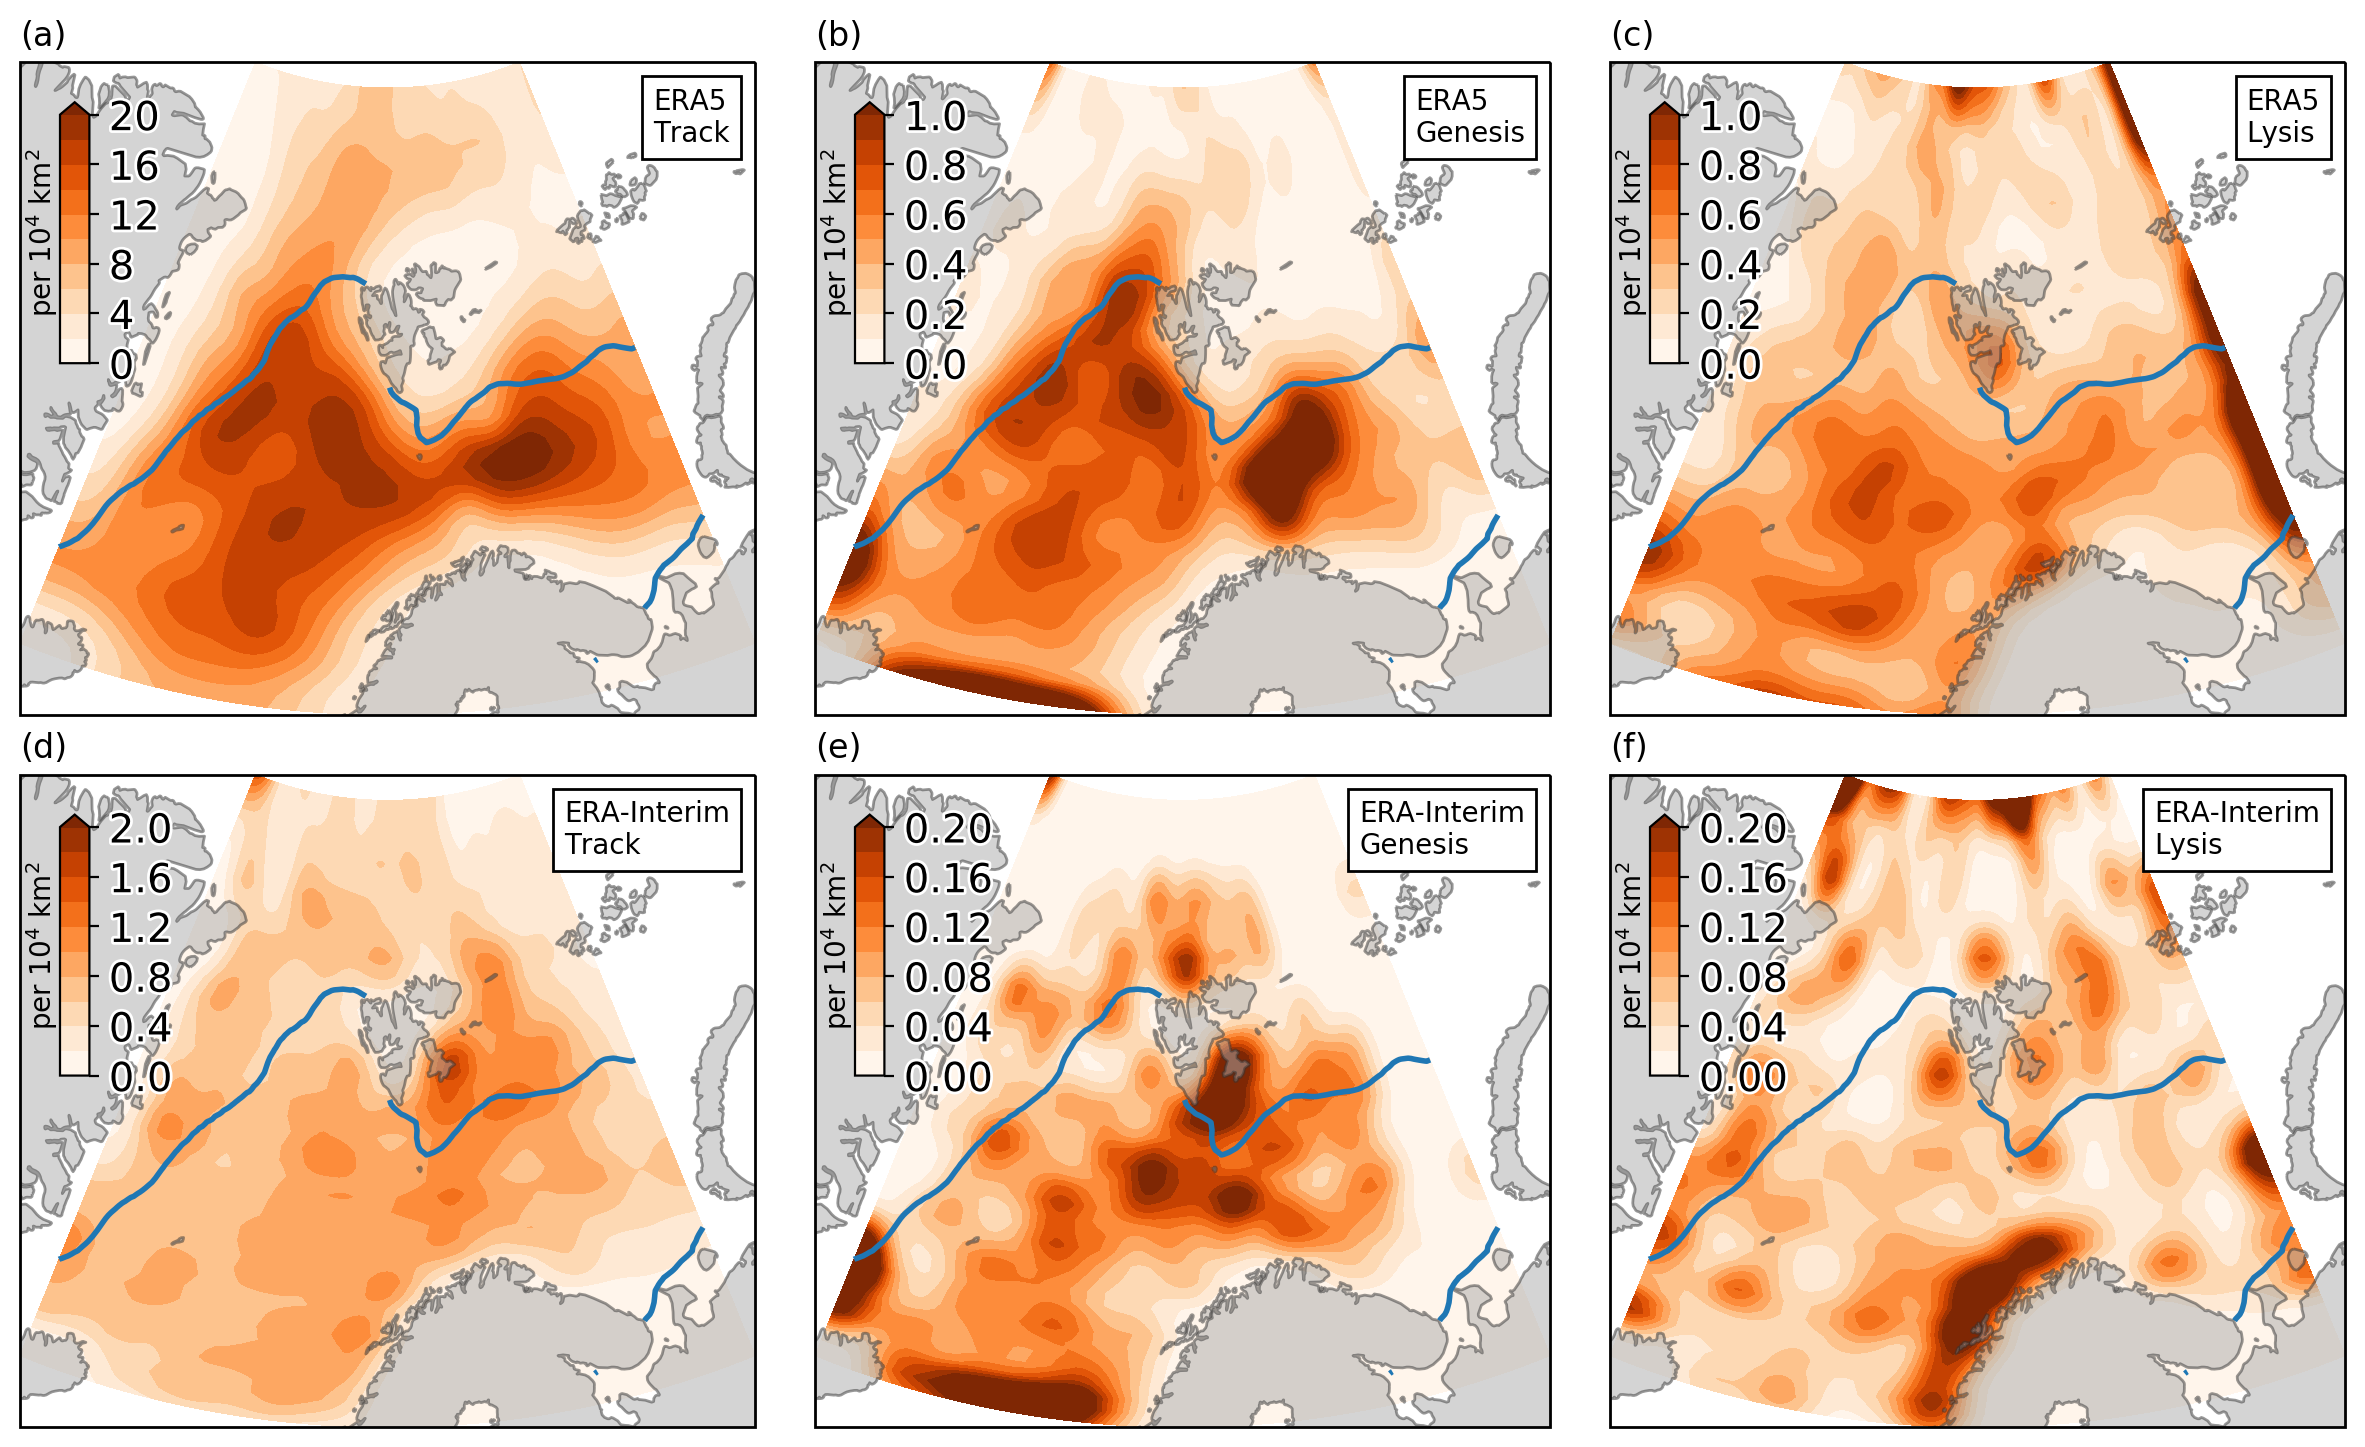

In [19]:
nrow = len(datasets)
ncol = len(density_types)

fig = plt.figure(figsize=(ncol * 5, nrow * 5))
axgr = lcc_map_grid(fig, (nrow, ncol), **LCC_KW, **AXGR_KW)

for axcol, dens_type in zip(axgr.axes_column, density_types):
    

    # ttl = f"{dens_type.capitalize()}\n{period.replace('_', '-')} ({nyr} winters)"
    #     fig.suptitle(
    #         ttl,
    #         x=axgr.axes_all[0].get_position().get_points()[0, 0],
    #         transform=axgr.axes_all[0].transAxes,
    #         ha="left",
    #         fontsize="large",
    #     )

    
    # iter_cax = iter(axgr.cbar_axes)
    for ax, dset in zip(axcol, datasets):
        run_num = runs2process[dset][0]

        data = dens_ds[dset].sel(subset=subset, dens_type=dens_type) * 1e4
        lab = aliases[dset]  # "\n".join(dset_label.split(", "))
        txt = f"{lab}\n{dens_type.capitalize()}"
        ax.add_artist(AnchoredText(txt, **at_kw))
        #             try:
        #                 h = data.plot.contourf(ax=ax, robust=True, add_colorbar=False, add_labels=False, **abs_plt_kw)
        #             except:
        h = data.plot.contourf(
            ax=ax, robust=True, add_colorbar=False, add_labels=False, levels=np.linspace(0, _lev_max[dset][dens_type], 11), **abs_plt_kw,
        )

        # Overlay with sea ice edge
        sea_ice_conc_mean.plot.contour(ax=ax, add_labels=False, colors="C0", **ci_kw)

        cax = inset_axes(ax, borderpad=0.9, width="4%", height="40%", loc="upper left")

        # cax = next(iter_cax)
        cb = fig.colorbar(h, orientation="vertical", cax=cax)
        # cb.ax.set_title("per $10^4$ $km^2$", size=8, loc='left')
        cb.ax.set_ylabel("per $10^4$ $km^2$", size=10, labelpad=0.05)
        cb.ax.yaxis.set_label_position("left")
        cb.ax.tick_params(labelsize="large")
        for i in cb.ax.get_yticklabels():  #  + [cb.ax.title]:
            i.set_path_effects([PathEffects.withStroke(linewidth=2, foreground="w")])

iletters = iter(string.ascii_lowercase)
for ax in axgr.axes_all:
    ax.set_title(f"({next(iletters)})", loc="left", fontsize="medium")

In [20]:
fig.savefig(mypaths.plotdir / f'density_maps__{"_".join(density_types)}')